In [2]:
from plot_helpers import *
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats 
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
from scipy.stats import linregress
import matplotlib as mpl

# Set global font sizes - for manuscript
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24
mpl.rcParams['legend.fontsize'] = 18


In [3]:
# Load the statistics CSV file
combined_statistics_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"
df = pd.read_csv(combined_statistics_path)

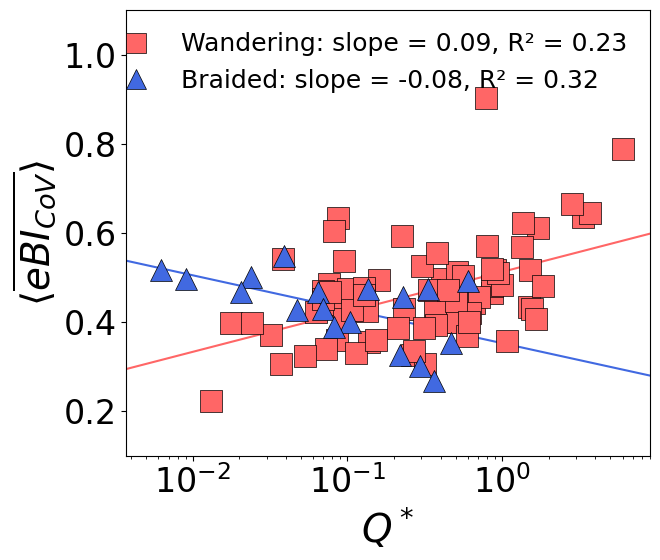

In [4]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['dim_Q'].min() * 0.6, df['dim_Q'].max() * 1.5)

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Loop through each group to compute and plot the regression line.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['dim_Q']
    y_data = subset['cov_ebi_site']
    
    # Ensure x_data are positive (needed for log transformation)
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit regression using the unified function with mode "log-x"
    slope, intercept, predict = fit_regression(x_data, y_data, mode="log-x")
    
    # Generate regression line values over the full x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)
    
    # Compute R² on the original data
    y_pred = predict(x_data)
    ss_res = ((y_data - y_pred) ** 2).sum()
    ss_tot = ((y_data - y_data.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    
    # Store slope and R² information for the legend
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['dim_Q']
    y_data = subset['cov_ebi_site']
    
    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis to log scale and adjust limits
ax.set_xscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(bottom=0.1, top=1.1)

# Set labels and tick parameters
ax.set_xlabel(r'${Q^*}$')  # X-axis labeled as Q*
ax.set_ylabel(r'$\langle\overline{\mathit{eBI_{CoV}}}\rangle$')
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² information
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\6_eBI_cov_intermittency.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)


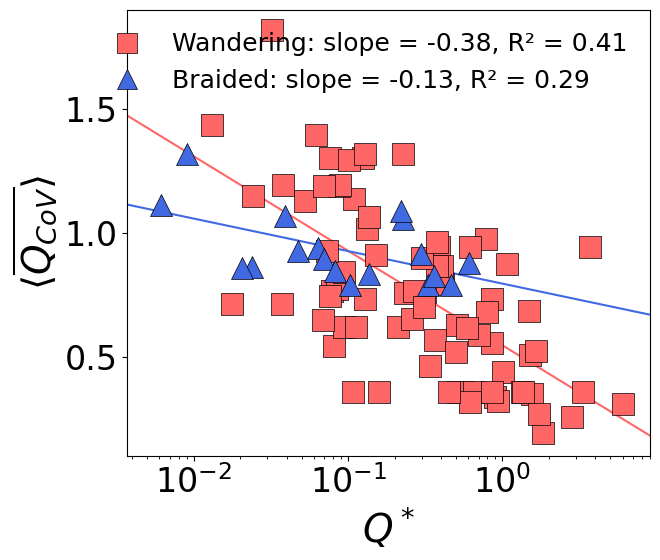

In [12]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['dim_Q'].min() * 0.6, df['dim_Q'].max() * 1.5)

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Loop through each group to compute and plot the regression line.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['dim_Q']
    y_data = subset['cov_discharge_site']
    
    # Ensure x_data are positive (needed for log transformation)
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit regression using the unified function with mode "log-x"
    slope, intercept, predict = fit_regression(x_data, y_data, mode="log-x")
    
    # Generate regression line values over the full x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)
    
    # Compute R² on the original data
    y_pred = predict(x_data)
    ss_res = ((y_data - y_pred) ** 2).sum()
    ss_tot = ((y_data - y_data.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    
    # Store slope and R² information for the legend
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['dim_Q']
    y_data = subset['cov_discharge_site']
    
    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis to log scale and adjust limits
ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlim(*x_range)
#ax.set_ylim(bottom=0.1, top=1.1)

# Set labels and tick parameters
ax.set_xlabel(r'${Q^*}$')  # X-axis labeled as Q*
ax.set_ylabel(r'$\langle\overline{\mathit{Q_{CoV}}}\rangle$')
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² information
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

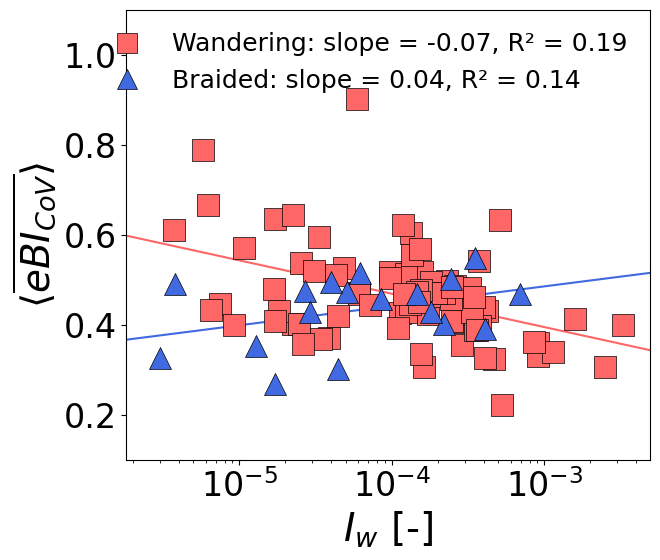

In [ ]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['dim_Q'].min() * 0.6, df['dim_Q'].max() * 1.5)

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Loop through each group to compute and plot the regression line.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['dim_Q']
    y_data = subset['cov_ebi_site']
    
    # Ensure x_data are positive (needed for log transformation)
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit regression using the unified function with mode "log-x"
    slope, intercept, predict = fit_regression(x_data, y_data, mode="log-x")
    
    # Generate regression line values over the full x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)
    
    # Compute R² on the original data
    y_pred = predict(x_data)
    ss_res = ((y_data - y_pred) ** 2).sum()
    ss_tot = ((y_data - y_data.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    
    # Store slope and R² information for the legend
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['dim_Q']
    y_data = subset['cov_ebi_site']
    
    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis to log scale and adjust limits
ax.set_xscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(bottom=0.1, top=1.1)

# Set labels and tick parameters
ax.set_xlabel(r'${Q^*}$')  # X-axis labeled as Q*
ax.set_ylabel(r'$\langle\overline{\mathit{eBI_{CoV}}}\rangle$')
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² information
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

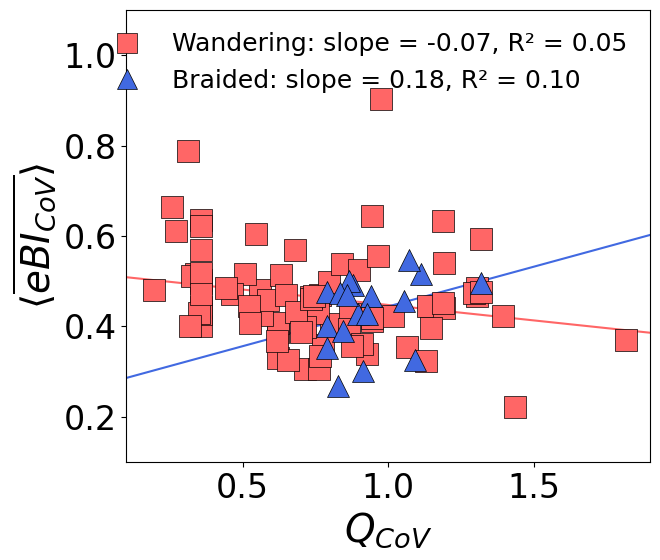

In [83]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['cov_discharge_site'].min() * 0.4, df['cov_discharge_site'].max() * 1.5)

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Loop through each group to compute and plot the regression line.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['cov_discharge_site']
    y_data = subset['cov_ebi_site']
    
    # Ensure x_data are positive (needed for log transformation)
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit regression using the unified function with mode "log-x"
    slope, intercept, predict = fit_regression(x_data, y_data, mode="linear")
    
    # Generate regression line values over the full x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)
    
    # Compute R² on the original data
    y_pred = predict(x_data)
    ss_res = ((y_data - y_pred) ** 2).sum()
    ss_tot = ((y_data - y_data.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    
    # Store slope and R² information for the legend
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['cov_discharge_site']
    y_data = subset['cov_ebi_site']
    
    # Optionally, uncomment the errorbar line if desired:
    # ax.errorbar(x_data, y_data, yerr=error_data, fmt='none',
    #             ecolor='black', elinewidth=2, capsize=5, zorder=1)
    
    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis to log scale and adjust limits
#ax.set_xscale('log')
ax.set_xlim(0.1, 1.9)
ax.set_ylim(bottom=0.1, top=1.1)

# Set labels and tick parameters
ax.set_xlabel(r'${Q_{CoV}}$')
ax.set_ylabel(r'$\langle\overline{\mathit{eBI_{CoV}}}\rangle$')
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² information
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle="None"),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle="None")
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\6_eBI_cov_annual.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

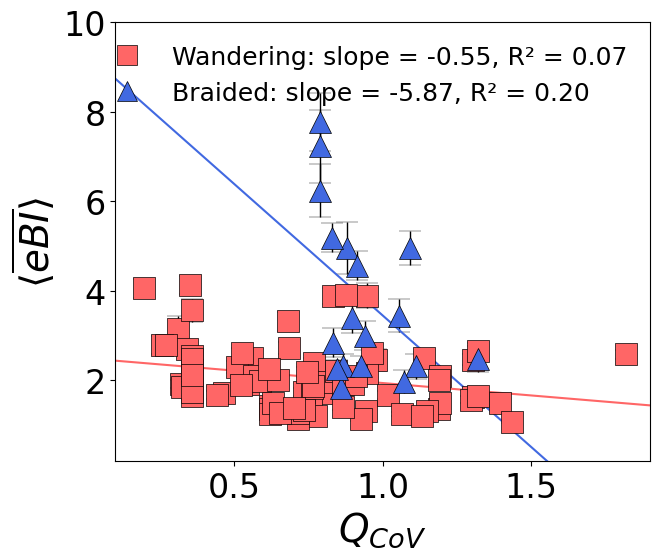

In [84]:
x_range = (df['cov_discharge_site'].min() * 0.4, df['cov_discharge_site'].max() * 1.5)

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Loop through each group to compute and plot the regression line.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['cov_discharge_site']
    y_data = subset['mean_ebi_site']
    
    # Ensure x_data are positive (needed for log transformation)
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit regression using the unified function with mode "log-x"
    slope, intercept, predict = fit_regression(x_data, y_data, mode="linear")
    
    # Generate regression line values over the full x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)
    
    # Compute R² on the original data
    y_pred = predict(x_data)
    ss_res = ((y_data - y_pred) ** 2).sum()
    ss_tot = ((y_data - y_data.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    
    # Store slope and R² information for the legend
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['cov_discharge_site']
    y_data = subset['mean_ebi_site']
    
    n = len(subset)
    y_error = subset['std_ebi_site'] / np.sqrt(n)
    
    # Plot error bars.
    ax.errorbar(x_data, y_data, yerr=y_error, fmt='none', ecolor='black',
                capsize=8, alpha=1, zorder=1,capthick=0.3, elinewidth=1)
    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis to log scale and adjust limits
#ax.set_xscale('log')
ax.set_xlim(0.1, 1.9)
ax.set_ylim(bottom=0.2, top=10)

# Set labels and tick parameters
ax.set_xlabel(r'${Q_{CoV}}$')
ax.set_ylabel(r'$\langle\overline{\mathit{eBI}}\rangle$')
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² information
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\6_eBIm_cov_annual.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

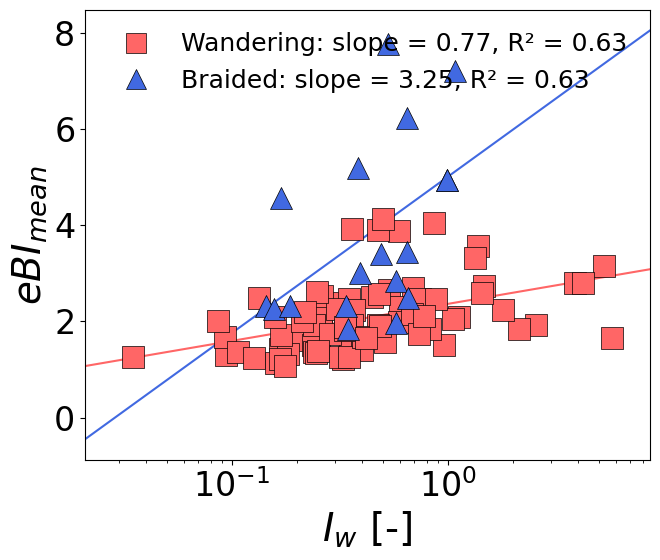

In [35]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['Iw'].min() * 0.6, df['Iw'].max() * 1.5)

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Loop through each group to compute and plot the regression line.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Iw']
    y_data = subset['mean_ebi_site']
    
    # Ensure x_data are positive (needed for log transformation)
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit regression using the unified function with mode "log-x"
    slope, intercept, predict= fit_regression(x_data, y_data, mode="log-x")
    
    # Generate regression line values over the full x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)

    
    # Store slope and R² information for the legend
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Iw']
    y_data = subset['mean_ebi_site']
    
    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis to log scale and adjust limits
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(*x_range)
#ax.set_ylim(bottom=0.1, top=1.1)

# Set labels and tick parameters
ax.set_xlabel(r'${I_{w}}$ [-]')  # Display fraction as LaTeX
ax.set_ylabel(r'${eBI_{mean}}$')  # Display fraction as LaTeX
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² information
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

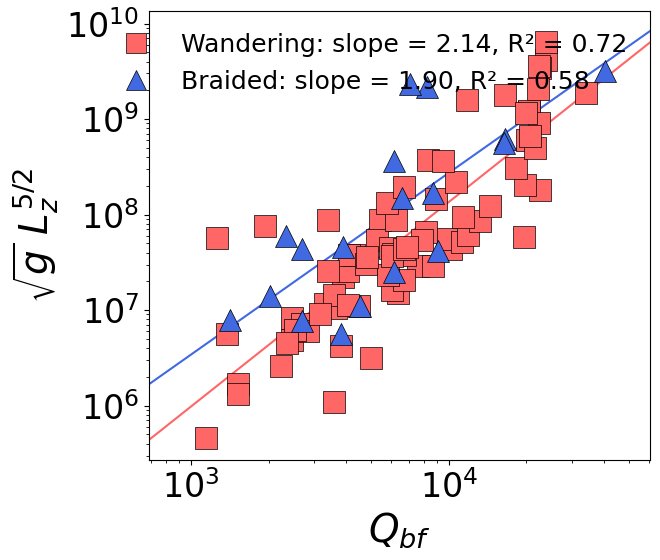

In [27]:
# gravitational acceleration
g = 9.81

# Dynamically calculate x_range based on data (with padding)
x_range = (df['Qbf point'].min() * 0.6, df['Qbf point'].max() * 1.5)

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Loop through each group to compute and plot the regression line.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Qbf point']
    # transform the y-data
    y_data = np.sqrt(g) * subset['wetted_area_avg_subannual']**2.5

    # Ensure x_data are positive (needed for log transform)
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")

    # Fit regression using the unified function with mode="log-log"
    slope, intercept, predict, r2 = fit_regression(x_data, y_data, mode="log-log", return_r2=True)

    # Generate regression line values over the full x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)

    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)

    # Store slope and R² information for the legend
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Plot data points
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Qbf point']
    y_data = np.sqrt(g) * subset['wetted_area_avg_subannual']**2.5

    ax.scatter(
        x_data, y_data,
        label=group,
        marker=markers[group],
        c=colors[group],
        edgecolors='black',
        s=250,
        zorder=2,
        linewidths=0.5,
        alpha=1
    )

# Set log–log scales and limits
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(*x_range)

# Labels
ax.set_xlabel(r'${Q_{bf}}$')
ax.set_ylabel(r'$\sqrt{g}\;L_z^{5/2}$')

# Custom legend with slope & R²
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15,
           markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15,
           markeredgecolor='black', markeredgewidth=0.5, linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

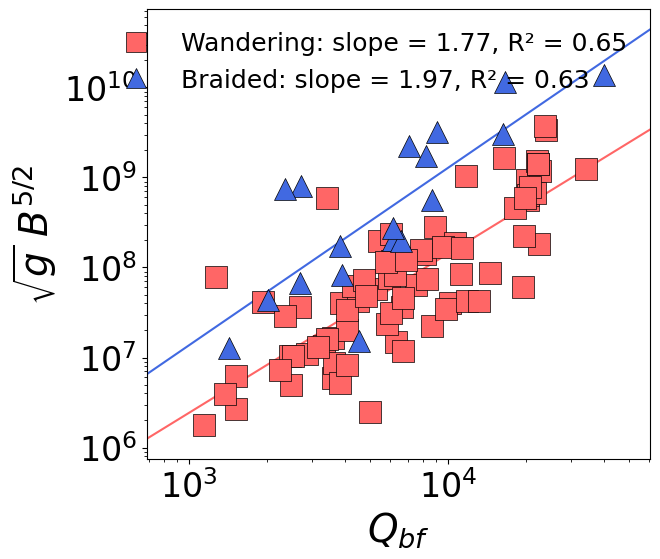

In [30]:
# gravitational acceleration
g = 9.81

# Dynamically calculate x_range based on data (with padding)
x_range = (df['Qbf point'].min() * 0.6, df['Qbf point'].max() * 1.5)

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Loop through each group to compute and plot the regression line.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Qbf point']
    # transform the y-data
    y_data = np.sqrt(g) * subset['Width(m)']**2.5

    # Ensure x_data are positive (needed for log transform)
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")

    # Fit regression using the unified function with mode="log-log"
    slope, intercept, predict, r2 = fit_regression(x_data, y_data, mode="log-log", return_r2=True)

    # Generate regression line values over the full x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)

    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)

    # Store slope and R² information for the legend
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Plot data points
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Qbf point']
    y_data = np.sqrt(g) * subset['Width(m)']**2.5

    ax.scatter(
        x_data, y_data,
        label=group,
        marker=markers[group],
        c=colors[group],
        edgecolors='black',
        s=250,
        zorder=2,
        linewidths=0.5,
        alpha=1
    )

# Set log–log scales and limits
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(*x_range)

# Labels
ax.set_xlabel(r'${Q_{bf}}$')
ax.set_ylabel(r'$\sqrt{g}\;B^{5/2}$')

# Custom legend with slope & R²
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15,
           markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15,
           markeredgecolor='black', markeredgewidth=0.5, linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()